# <center><span style="color:black"> Convnets : using image classification of Malaria infected cells as an introductory example </style></center>
###  <center><span style="color:black"> Student : Khalil Zlaoui </style></center> 

- Our objective is to be able to tell whether or not a $\textbf{human cell is infected with Malaria}$, without requiring the expertise of a physician, to reduce the burden for microscopists in resource-constrained regions and improve Malaria screening accuracy



- To this end, we use convolutional neural networks (CNN)


- The dataset is made of a 27,558 images with equal instances of "parasitized" and "uninfected" cells, and was transferred from the NIH https://ceb.nlm.nih.gov/repositories/malaria-datasets/ to Kaggle https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. Images represent human cells, with a marker that should be able differenciate between cells parasitized by Malaria from uninfected cells

# OUR FIRST CONVNET

In [2]:
#img_size=97
img_size=50

## STEP 1 : Downloading dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

# cv2 installation:
# pip install opencv-python

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

datadir = "/Volumes/External/Kaggle/cell_images"
data= []
categories=["0","1"]


for category in categories:
    
    path=os.path.join(datadir,category) # path to end directory

    for img in listdir_nohidden(path):
        #print(img)
        
        # read the image array
        img_array = cv2.imread(os.path.join(path,img))
        
        # This next step converts the image to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Reshape all images
        new_image_array = cv2.resize(img_array,(img_size,img_size))
        #plt.imshow(new_image_array)

        data.append([new_image_array.astype('int'),category])

## STEP 2 : Shuffle data, define X and Y, pickle data

In [4]:
# Check length of training data
print(len(data))

import random
random.shuffle(data)

27558


In [5]:
# Define X as features and Y as class

X=[]
Y=[]  

for features, label in data:
    X.append(features)
    Y.append(label)

#### Save  data for easy retrieval

In [ ]:
import pickle

pickle_out = open("/Volumes/External/Kaggle/X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("/Volumes/External/Kaggle/Y.pickle","wb")
pickle.dump(Y,pickle_out)
pickle_out.close()

#### Retrieve training data from pickle

In [14]:
import pickle

pickle_in = open("/Volumes/External/Kaggle/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/Volumes/External/Kaggle/Y.pickle","rb")
Y = pickle.load(pickle_in)

#### Test and train set 

In [6]:
train = round(2*len(X)/3)
test = round(len(X)/3)
print(train)
print(test)

X_train = X[0:train]
X_test = X[train:len(X)+1]

Y_train = Y[0:train]
Y_test = Y[train:len(X)+1]

18372
9186


## STEP 3 : Visualizing data

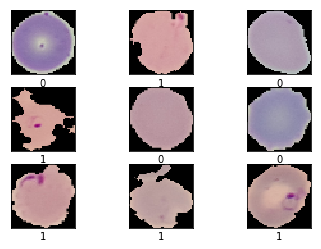

In [7]:
import matplotlib.pyplot as plt
import random

r=random.randint(1,27000)

# Vizualize by grid

for i in range(0,9):
    plt.subplot(3,3,i+1)

    # Remove ticks from x and y (number of pixels)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i+r])
    plt.imshow(X[i+r],cmap="gray")
    plt.xlabel(Y[i+r])

- We chose our images to be of $\textbf{size 50 $*$ 50}$. We need to convert the image matrix into an array, normalize it (to be between zero and one), and reshape it so that it is of size 50 by 50 by 3, where 3 represents the R, G and B values. We will then feed this as input to the network.

## STEP 4 : Formatting for Keras

In [8]:
import numpy as np

# X has to be a numpy array, as required by Keras

#For RGB
X_train = np.array(X_train).reshape(-1,img_size,img_size,3)
X_test = np.array(X_test).reshape(-1,img_size,img_size,3)

# Transform Y to integers
Y_train = list(map(int, Y_train))
Y_test = list(map(int, Y_test))

# Normalizing data: 
Normalized_X_train = X_train/255.0
Normalized_X_test = X_test/255.0

# 3 if color, 1 if gray
Color_dim=3
#print(Normalized_X_train)
#print(Normalized_X_test)

print("X train shape :",Normalized_X_train.shape[1:],"Y train shape:",len(Y_train))
print("X test shape :",Normalized_X_test.shape[1:],"Y test shape:",len(Y_test))

# Y should be integers
#type(Y[0])
#print(Y)
#print(Normalized_X)

X train shape : (50, 50, 3) Y train shape: 18372
X test shape : (50, 50, 3) Y test shape: 9186


## STEP 5 : Baseline model : Let's start with a basic convolutional neural network

In [9]:
# Let's define our model

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import regularizers
from keras.layers.core import Dropout

model= Sequential()

# First convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model.add(Conv2D(32,(3,3),input_shape=Normalized_X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten     
model.add(Flatten())

# Add last layer for the output
model.add(Dense(1))
model.add(Activation("sigmoid"))

Using TensorFlow backend.


In [10]:
# Optimizer : Adam
# Loss : Binary cross entropy
# metrics : Accuracy

model.compile(loss="binary_crossentropy",optimizer="adam",
             metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0

In [12]:
train=model.fit(Normalized_X_train,Y_train,batch_size=30,epochs=10,validation_data=(Normalized_X_test, Y_test))

Train on 18372 samples, validate on 9186 samples
Epoch 1/10
18372/18372 [==============================] - 36s 2ms/sample - loss: 0.6220 - accuracy: 0.6457 - val_loss: 0.5874 - val_accuracy: 0.6749
Epoch 2/10
18372/18372 [==============================] - 29s 2ms/sample - loss: 0.4407 - accuracy: 0.8093 - val_loss: 0.2831 - val_accuracy: 0.8979
Epoch 3/10
18372/18372 [==============================] - 26s 1ms/sample - loss: 0.2243 - accuracy: 0.9215 - val_loss: 0.1841 - val_accuracy: 0.9352
Epoch 4/10
18372/18372 [==============================] - 27s 1ms/sample - loss: 0.1686 - accuracy: 0.9419 - val_loss: 0.1694 - val_accuracy: 0.9463
Epoch 5/10
18372/18372 [==============================] - 27s 1ms/sample - loss: 0.1516 - accuracy: 0.9491 - val_loss: 0.1552 - val_accuracy: 0.9481
Epoch 6/10
18372/18372 [==============================] - 27s 1ms/sample - loss: 0.1406 - accuracy: 0.9523 - val_loss: 0.1505 - val_accuracy: 0.9511
Epoch 7/10
18372/18372 [==============================] -

Let's save the model so that we can directly load it directly instead of training it if needed later. Later, we can load the model even if we need to modify the structure of the network. It is always a good to save the model (and even the model's weights)  because it saves time.

In [35]:
model.save("train_model_10_epoch_30_batch.h5py")

In [1]:
import h5py
model=h5py.File('model_10_epoch_30_batch.h5py', 'r')

## STEP 5 : Training vs. Testing accuracy plot 

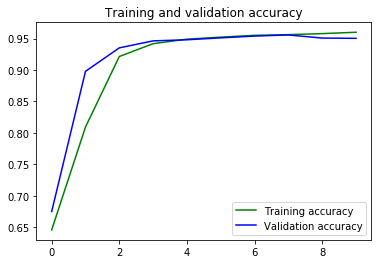

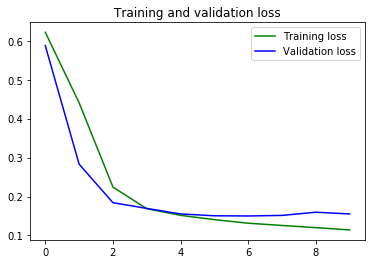

In [13]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

- This is actually looking pretty nice ! 

Note that smaller datasets have smaller intrinsic variance. Train error is greater for the training set in the first few epoch rounds because the inner variance of training set is greater then validation set. This also might have occured by chance.

## STEP 6 : Image predictions 

In [14]:
predicted_classes = model.predict(Normalized_X_test)
predicted_classes = np.round(predicted_classes)
predicted_classes.shape
Y_test_df=pd.DataFrame(Y_test)
predicted_classes.shape, Y_test_df.shape
correct = np.where(predicted_classes==Y_test_df)[0]
print ("Found %d correct labels" % len(correct) , "out of", len(Y_test_df), ",i.e",str(round(len(correct)/len(Y_test_df),3)*100)+"% accuracy on validation set.")

Found 8730 correct labels out of 9186 ,i.e 95.0% accuracy on validation set.


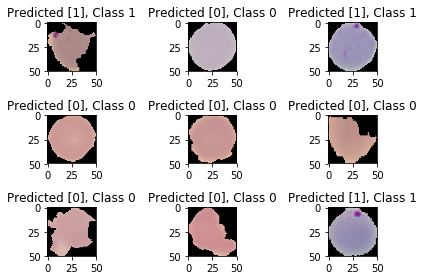

In [15]:
for (i,corr) in enumerate(correct[:9]):
    #print(i,corr)
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[corr].reshape(50,50,3),interpolation='none')
    #print(predicted_classes[corr].astype(int))
    
    plt.title("Predicted {}, Class {}".format(predicted_classes[corr].astype(int), Y_test[corr]))
    plt.tight_layout()

# FIRST CONCLUSIONS

We see that with a simple convnet, we already reached a prediction accuracy of 95% on the validation set!
But we did not really tune our parameters yet. There are a lot of things we could do:

- $\textbf{Data augmentation}$ : this consists adding more data by pivoting images, randomly cropping them etc.


- $\textbf{Changing epochs and batch size}$ : this contributes massively to determining the learning parameters and affects the prediction accuracy.


- $\textbf{Adding layers}$ : Let's not forget that this is a deep learning algorithm. As we add layers, the model becomes deeper. We need to be careful not to make the model too deep or too wide, because this is computationally not efficient.


- $\textbf{Hyperparameters}$ : We can test convolutional filters with several dimensions, several layers, several pooling methods (maximum, average etc.) and several activation functions (e.g. relu/ elu etc.). We can also use Bayesian finetuning, which is an efficient way of finding the best hyperparameters.


- $\textbf{Dropout}$ : to avoid overfitting, we may use dropout, which consists in dopping elements in either hidden or dense layers.


- $\textbf{Penalization, striding, padding}$: We can also use penalization on the weights, striding and padding, which are other ways of reducing the chance of overfitting on the test set. Stride is the size of the step the convolution filter moves each time. A stride size is usually 1, meaning the filter slides pixel by pixel. By increasing the stride size, the filter is sliding over the input with a larger interval and thus has less overlap between the cells.


etc...

# WHAT WE WILL DO : 
    
Empirically, maxpooling, relu activation function, and the optimizer adam are good for this type of problem, so we will not play with these parameters. Additionally, although this is a standard approach in model tuning, it will take us hours to do a grid search to use optimal epochs and batch size. So instead, we will try to overfit the training set, and then tune our convnet. We will be testing the following :

    
- We will change the number of layers (the convnet depth), and make the convnet deep enough so that it overfits the training data.


- We will use some penalization to reduce overfitting and increase our validation error (we will test dropout, and batch normalization)


- Data augmentation?

## Model 2 : More depth + penalization to reduce overfitting

In [16]:
# Let's define our model

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
#from keras.layers.core import Dropout

model_final = Sequential()

# First convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3),input_shape=Normalized_X_train.shape[1:]))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
model_final.add(Dropout(0.2))


# Second convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
model_final.add(Dropout(0.2))
                  
# Third convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
#Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
model_final.add(Dropout(0.2))

#  Add last dense layer                  
model_final.add(Dense(100))
model_final.add(Dropout(0.5))
                
model_final.add(Flatten())

model_final.add(Dense(1))
model_final.add(Activation("sigmoid"))

In [17]:
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)       

In [18]:
model_final.compile(loss="binary_crossentropy",optimizer="adam",
             metrics=["accuracy"])

In [19]:
train_final=model_final.fit(Normalized_X_train,Y_train,batch_size=30,epochs=20,validation_data=(Normalized_X_test, Y_test))


Train on 18372 samples, validate on 9186 samples
Epoch 1/20
18372/18372 [==============================] - 36s 2ms/sample - loss: 0.5620 - accuracy: 0.6997 - val_loss: 0.2835 - val_accuracy: 0.8821
Epoch 2/20
18372/18372 [==============================] - 37s 2ms/sample - loss: 0.2248 - accuracy: 0.9229 - val_loss: 0.2264 - val_accuracy: 0.9234
Epoch 3/20
18372/18372 [==============================] - 36s 2ms/sample - loss: 0.1923 - accuracy: 0.9364 - val_loss: 0.1762 - val_accuracy: 0.9495
Epoch 4/20
18372/18372 [==============================] - 37s 2ms/sample - loss: 0.1789 - accuracy: 0.9414 - val_loss: 0.1783 - val_accuracy: 0.9339
Epoch 5/20
18372/18372 [==============================] - 38s 2ms/sample - loss: 0.1732 - accuracy: 0.9434 - val_loss: 0.1625 - val_accuracy: 0.9479
Epoch 6/20
18372/18372 [==============================] - 37s 2ms/sample - loss: 0.1706 - accuracy: 0.9448 - val_loss: 0.1932 - val_accuracy: 0.9258
Epoch 7/20
18372/18372 [==============================] -

- We observe that the test accuracy is higher than the traning accuracy. It might seem like something went wrong but in fact, This happens when using dropout, since the behaviour when training and testing are different.


- When training, a percentage of the features are set to zero (20% in this case since we are using Dropout(0.2)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

### Validation plots

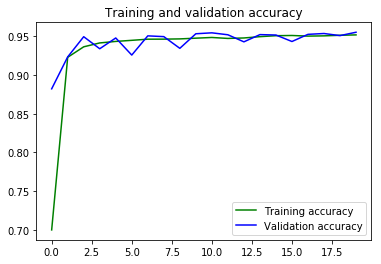

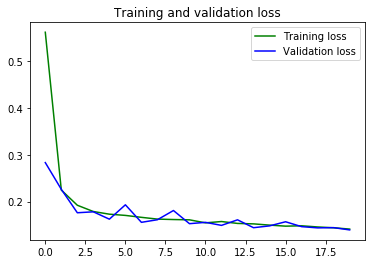

In [20]:
accuracy = train_final.history['accuracy']
val_accuracy = train_final.history['val_accuracy']
loss = train_final.history['loss']
val_loss = train_final.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Let's loook at the well classified images, then the misclassified images

### Classification

Found 8775 correct labels out of 9186 ,i.e 95.5% accuracy on validation set.


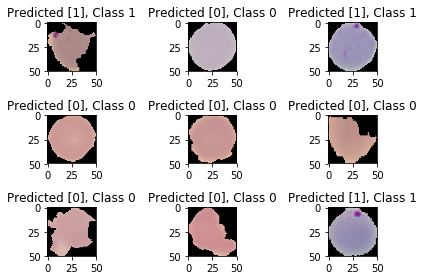

In [21]:
predicted_classes = model_final.predict(Normalized_X_test)
predicted_classes = np.round(predicted_classes)
predicted_classes.shape
Y_test_df=pd.DataFrame(Y_test)
predicted_classes.shape, Y_test_df.shape
correct = np.where(predicted_classes==Y_test_df)[0]
print ("Found %d correct labels" % len(correct) , "out of", len(Y_test_df), ",i.e",str(round(len(correct)/len(Y_test_df),3)*100)+"% accuracy on validation set.")

for (i,corr) in enumerate(correct[:9]):
    #print(i,corr)
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[corr].reshape(50,50,3),interpolation='none')
    #print(predicted_classes[corr].astype(int))
    
    plt.title("Predicted {}, Class {}".format(predicted_classes[corr].astype(int), Y_test[corr]))
    plt.tight_layout()

## Batch normalization

In [23]:
# Let's define our model

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
#from keras.layers.core import Dropout

chanDim = -1
model_final = Sequential()

# First convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3),input_shape=Normalized_X_train.shape[1:]))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))


# Second convolution layer (64 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))
                  
# Third convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
#Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))

#  Add last dense layer                  
model_final.add(Dense(300))
model_final.add(BatchNormalization(axis = chanDim))
                
model_final.add(Flatten())

model_final.add(Dense(1))
model_final.add(Activation("sigmoid"))

In [24]:
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)       

In [25]:
model_final.compile(loss="binary_crossentropy",optimizer="adam",
             metrics=["accuracy"])

In [27]:
train_final=model_final.fit(Normalized_X_train,Y_train,batch_size=30,epochs=30,validation_data=(Normalized_X_test, Y_test))


Train on 18372 samples, validate on 9186 samples
Epoch 1/30
18372/18372 [==============================] - 62s 3ms/sample - loss: 0.1452 - accuracy: 0.9506 - val_loss: 0.1746 - val_accuracy: 0.9520
Epoch 2/30
18372/18372 [==============================] - 58s 3ms/sample - loss: 0.1398 - accuracy: 0.9526 - val_loss: 0.2144 - val_accuracy: 0.9410
Epoch 3/30
18372/18372 [==============================] - 59s 3ms/sample - loss: 0.1304 - accuracy: 0.9550 - val_loss: 0.1792 - val_accuracy: 0.9458
Epoch 4/30
18372/18372 [==============================] - 58s 3ms/sample - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.1772 - val_accuracy: 0.9541
Epoch 5/30
18372/18372 [==============================] - 65s 4ms/sample - loss: 0.1188 - accuracy: 0.9578 - val_loss: 0.1722 - val_accuracy: 0.9472
Epoch 6/30
18372/18372 [==============================] - 63s 3ms/sample - loss: 0.1128 - accuracy: 0.9608 - val_loss: 0.1765 - val_accuracy: 0.9444
Epoch 7/30
18372/18372 [==============================] -

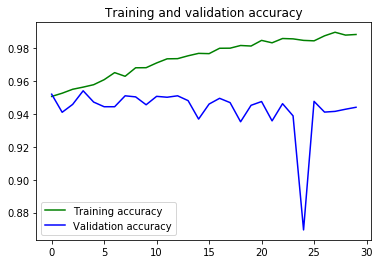

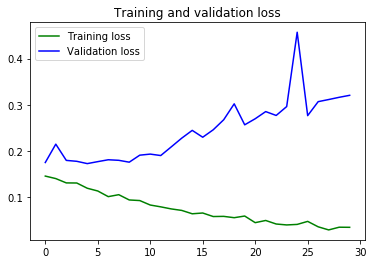

In [31]:
accuracy = train_final.history['accuracy']
val_accuracy = train_final.history['val_accuracy']
loss = train_final.history['loss']
val_loss = train_final.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Dropout and batch normalization

In [41]:
# Let's define our model

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
#from keras.layers.core import Dropout

chanDim = -1
model_final = Sequential()

# First convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3),input_shape=Normalized_X_train.shape[1:]))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))

# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))
model_final.add(Dropout(0.1))

# Second convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
# Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))
model_final.add(Dropout(0.1))    
    
# Third convolution layer (32 hidden layers, 3 by 3 filter, then maxpooling using 2 by 2 filter)
#Activation function : Relu
model_final.add(Conv2D(32,(3,3)))
model_final.add(Activation("relu"))
model_final.add(MaxPooling2D(pool_size=(2,2)))
# Add batch normalization
model_final.add(BatchNormalization(axis = chanDim))
model_final.add(Dropout(0.1))

#  Add last dense layer                  
model_final.add(Dense(300))
model_final.add(BatchNormalization(axis = chanDim))
model_final.add(Dropout(0.5))
                
model_final.add(Flatten())

model_final.add(Dense(1))
model_final.add(Activation("sigmoid"))

In [42]:
model_final.compile(loss="binary_crossentropy",optimizer="adam",
             metrics=["accuracy"])

In [43]:
train_final=model_final.fit(Normalized_X_train,Y_train,batch_size=20,epochs=30,validation_data=(Normalized_X_test, Y_test))

Train on 18372 samples, validate on 9186 samples
Epoch 1/30
18372/18372 [==============================] - 106s 6ms/sample - loss: 0.4604 - accuracy: 0.8174 - val_loss: 0.2241 - val_accuracy: 0.9209
Epoch 2/30
18372/18372 [==============================] - 103s 6ms/sample - loss: 0.2461 - accuracy: 0.9159 - val_loss: 0.1651 - val_accuracy: 0.9449
Epoch 3/30
18372/18372 [==============================] - 93s 5ms/sample - loss: 0.2228 - accuracy: 0.9287 - val_loss: 0.1944 - val_accuracy: 0.9368
Epoch 4/30
18372/18372 [==============================] - 68s 4ms/sample - loss: 0.2186 - accuracy: 0.9308 - val_loss: 0.1995 - val_accuracy: 0.9348
Epoch 5/30
18372/18372 [==============================] - 68s 4ms/sample - loss: 0.2052 - accuracy: 0.9336 - val_loss: 0.1691 - val_accuracy: 0.9455
Epoch 6/30
18372/18372 [==============================] - 68s 4ms/sample - loss: 0.1991 - accuracy: 0.9386 - val_loss: 0.1686 - val_accuracy: 0.9537
Epoch 7/30
18372/18372 [==============================]

## Validation plots

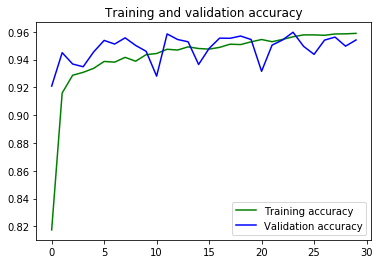

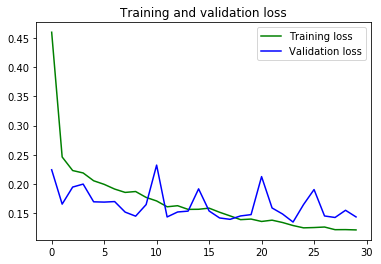

In [44]:
accuracy = train_final.history['accuracy']
val_accuracy = train_final.history['val_accuracy']
loss = train_final.history['loss']
val_loss = train_final.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Misclassification

Found 422 incorrect labels out of 9186 ,i.e 4.6% accuracy on validation set.


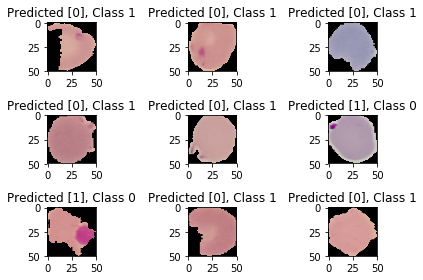

In [45]:
predicted_classes = model_final.predict(Normalized_X_test)
predicted_classes = np.round(predicted_classes)
predicted_classes.shape
Y_test_df=pd.DataFrame(Y_test)
predicted_classes.shape, Y_test_df.shape
correct = np.where(predicted_classes!=Y_test_df)[0]
print ("Found %d incorrect labels" % len(correct) , "out of", len(Y_test_df), ",i.e",str(round(len(correct)/len(Y_test_df),3)*100)+"% accuracy on validation set.")

for (i,corr) in enumerate(correct[:9]):
    #print(i,corr)
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[corr].reshape(50,50,3),interpolation='none')
    #print(predicted_classes[corr].astype(int))
    
    plt.title("Predicted {}, Class {}".format(predicted_classes[corr].astype(int), Y_test[corr]))
    plt.tight_layout()

# Going further ...

In practice, there are a lot of parameters to play with, and this can get computational very quickly. If we want to  do a:

- Grid search of the number of optimal epochs, batches, deep or wide layers, dropout parameter etc., the algorithm will take a lot of time to converge.

- Change optimizers, activation functions etc.

- Hyperparameters : We could instead use Bayesian finetuning, which is a good alternative to quickly finding optimal hyperparameters.

## Some useful links

https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca


https://www.youtube.com/watch?v=ttE0F7fghfk

https://machinelearningmastery.com/improve-deep-learning-performance/

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#classification

https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

https://www.datacamp.com/community/tutorials/cnn-tensorflow-python

https://www.topbots.com/14-design-patterns-improve-convolutional-neural-network-cnn-architecture/

https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8

https://medium.com/@jonathan_hui/improve-deep-learning-models-performance-network-tuning-part-6-29bf90df6d2d